# Steps

1. Data Preprocessing
    ---> Remove Noise
    ---> Create Train and Testing folder
2. Use ImageDataGenerator
    ---> Resize Images
    ---> Scale Data
    ---> And do some flipping, zooming, etc
3. Create a Model
4. Train Model
5. Evaluate the Model

In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from matplotlib.image import imread
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Data Preprocessing

In [13]:
os.listdir('raw_data')

['laptop', 'phone']

### Remove Noise

In [49]:
## We have to manually remove noise from data i.e if laptop category have another pictuer which does not resemble laptop
# done

### Creating Train and Test

In [5]:
train_path = 'data/train/'
test_path = 'data/test/'
source_path = 'raw_data/'
classes = ['phone/', 'laptop/']
test_ratio = 0.2

def move_to_train_and_test(train_path, test_path, source_path, class_name, test_ratio):
    
    phones = os.listdir(source_path + class_name)
    test_size = int(test_ratio * len(phones))
    test_data = phones[:test_size]
    train_data = phones[test_size:]
    
    ### moving files to test
    print("Moving test files....")
    
    for file in test_data:
        shutil.move(source_path + class_name + file, test_path + class_name + file)
    
    print("Finished Moving test files...")
        
    ### moving files to train
    print("Moving Train files....")
    
    for file in train_data:
        shutil.move(source_path + class_name + file, train_path + class_name + file)
        
    print("Finished Moving Train files.")

In [48]:
for i in classes:
    move_to_train_and_test(train_path, test_path, source_path, i, test_ratio)

Moving test files....
Finished Moving test files...
Moving Train files....
Finished Moving Train files.
Moving test files....
Finished Moving test files...
Moving Train files....
Finished Moving Train files.


## ImageDataGenerator

### Resize and Processing Images

In [22]:
dim1 = []
dim2 = []
products = ['phone']

for product in products:
    for file in os.listdir('raw_data/' + product):
        img = imread('raw_data/' + product + '/' + file)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

<Figure size 1080x576 with 0 Axes>

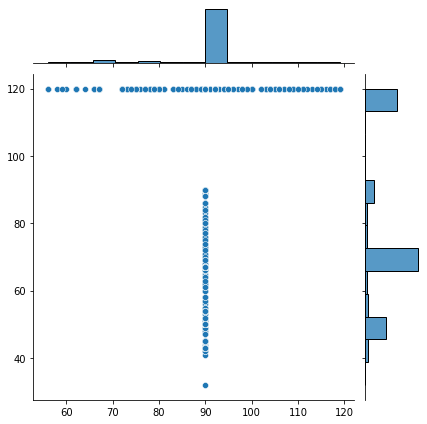

In [26]:
plt.figure(figsize = (15, 8))
sns.jointplot(x = dim1, y = dim2)

In [30]:
sum(dim1)/len(dim1)

88.80972818311874

In [31]:
sum(dim2)/len(dim2)

78.75011921793038

**I will be Resizing them to 83x83 and you can try resizing them to 80x80**

In [3]:
final_image_shape = (83, 83, 3)

In [3]:
image_gen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

In [6]:
train_img_gen = image_gen.flow_from_directory(train_path,
                                              target_size = final_image_shape[:2],
                                              color_mode = 'rgb',
                                              batch_size = 32,
                                              class_mode = 'binary',
                                              shuffle = True)

Found 3186 images belonging to 2 classes.


In [7]:
test_img_gen = image_gen.flow_from_directory(test_path,
                                              target_size = final_image_shape[:2],
                                              color_mode = 'rgb',
                                              batch_size = 32,
                                              class_mode = 'binary',
                                              shuffle = False)

Found 796 images belonging to 2 classes.


## Creating a Model

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

### Model Layers

In [4]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 1), input_shape = final_image_shape, activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (1, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 1), activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (1, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 1), activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (1, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 81, 83, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 81, 81, 32)        3104      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 40, 64)        6208      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 64)        12352     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 19, 64)        1

### Callbacks

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 2)

### Training

In [135]:
model.fit(train_img_gen, epochs = 30, validation_data = test_img_gen, callbacks = [earlystop])

Epoch 1/30
100/100 [==============================] - 58s 568ms/step - loss: 0.6936 - accuracy: 0.4983 - val_loss: 0.6769 - val_accuracy: 0.5264
Epoch 2/30
100/100 [==============================] - 54s 540ms/step - loss: 0.6563 - accuracy: 0.5934 - val_loss: 0.5597 - val_accuracy: 0.7312
Epoch 3/30
100/100 [==============================] - 54s 536ms/step - loss: 0.5362 - accuracy: 0.7197 - val_loss: 0.5617 - val_accuracy: 0.6910
Epoch 4/30
100/100 [==============================] - 54s 540ms/step - loss: 0.5155 - accuracy: 0.7506 - val_loss: 0.4413 - val_accuracy: 0.8003
Epoch 5/30
100/100 [==============================] - 54s 539ms/step - loss: 0.4315 - accuracy: 0.8057 - val_loss: 0.4573 - val_accuracy: 0.7915
Epoch 6/30
100/100 [==============================] - 54s 535ms/step - loss: 0.4424 - accuracy: 0.7886 - val_loss: 0.4284 - val_accuracy: 0.8141
Epoch 7/30
100/100 [==============================] - 54s 536ms/step - loss: 0.3930 - accuracy: 0.8258 - val_loss: 0.4387 - val_ac

In [133]:
model.save("Trained.h5")

## Evaluation

In [132]:
metrics = pd.DataFrame(model.history.history)

<AxesSubplot:>

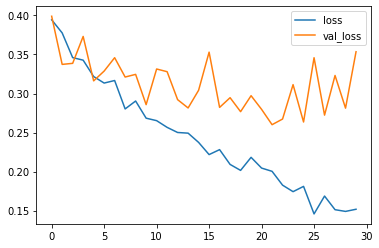

In [123]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

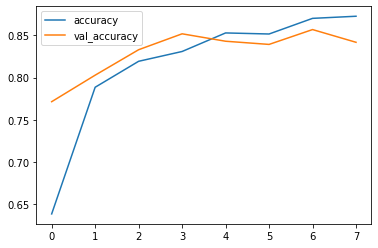

In [71]:
metrics[['accuracy', 'val_accuracy']].plot()

In [138]:
predictions = model.predict(test_img_gen)

In [139]:
predictions = (predictions > 0.5).astype('int16')

In [126]:
print(classification_report(test_img_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       377
           1       0.87      0.92      0.89       419

    accuracy                           0.89       796
   macro avg       0.89      0.88      0.88       796
weighted avg       0.89      0.89      0.89       796



In [127]:
confusion_matrix(test_img_gen.classes, predictions)

array([[321,  56],
       [ 35, 384]])

## Predicting on a new Image

In [28]:
testing_img = plt.imread('test/1.jpg')

In [29]:
testing_img.shape

(3120, 4160, 3)

In [113]:
test_img_gen.class_indices

{'laptop': 0, 'phone': 1}

In [42]:
img = Image.open('test/1.jpg').resize(final_image_shape[:2])

In [43]:
test_laptop_img = np.array(img).reshape(1, 83, 83, 3)/255

In [44]:
model.predict(test_laptop_img)

array([[0.08315828]], dtype=float32)

In [35]:
img = Image.open('test/2.jpg').resize(final_image_shape[:2])

In [38]:
test_phone_img = np.array(img).reshape(1, 83, 83, 3)/255

In [39]:
model.predict(test_phone_img)

array([[0.98503625]], dtype=float32)

## Deployment

### Prediction Function

In [144]:
def return_prediction(model, image):
    
    # Preprocess image
    img = Image.open(image).resize((83, 83))
    img = np.array(img).reshape(1, 83, 83, 3)
    
    # Predict the class
    classes = ['laptop', 'phone']
    class_ind = int(model.predict(img))
    
    # return prediction
    return classes[class_ind]

In [146]:
return_prediction(model, 'test/2.jpg')

'phone'